In [11]:
from pathlib import Path
from typing import Tuple, Optional, Iterable, Callable, List, Dict
from collections import OrderedDict
from copy import deepcopy

import cv2
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models import (
    swin_s,
    Swin_S_Weights,
    efficientnet_b7,
    EfficientNet_B7_Weights,
    efficientnet_b3,
    EfficientNet_B3_Weights,
    swin_v2_t,
    Swin_V2_T_Weights,
    swin_v2_s,
    Swin_V2_S_Weights,
    vit_b_16,
    ViT_B_16_Weights,
    densenet201,
    DenseNet201_Weights,
    googlenet,
    GoogLeNet_Weights,
    convnext_small,
    ConvNeXt_Small_Weights,
    regnet_y_8gf,
    RegNet_Y_8GF_Weights,
)
from torchvision.models.swin_transformer import Permute
from torchvision.io import read_image
from torchvision import transforms
from torchvision.ops import FeaturePyramidNetwork

from tqdm import tqdm

In [14]:
data_root = Path("../input/cropped-tires-with-labeled-depth/dataset_crop")

df = pd.read_csv(data_root / "thread_depths.csv")
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

In [13]:
MIN_DEPTH = 1.0
MAX_DEPTH = 10.0
STEP = 0.1
N_CLASSES = int((MAX_DEPTH - MIN_DEPTH) / STEP) + 1

In [4]:
class ThreadDataset(Dataset):
    def __init__(self, data: pd.DataFrame, data_root_dir: str, transform: Optional[nn.Module] = None):
        self.data = data
        self.data_root_dir = Path(data_root_dir)
        self.image_paths = []
        self.labels = []
        for _, row in self.data.iterrows():
            image_path = self.data_root_dir / row["path"]
            if not image_path.exists():
                print(f"Warning: {image_path} does not exist")
                continue
            self.image_paths.append(self.data_root_dir / row["path"])
            self.labels.append(row["label"])

        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, float]:
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = read_image(str(image_path))
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

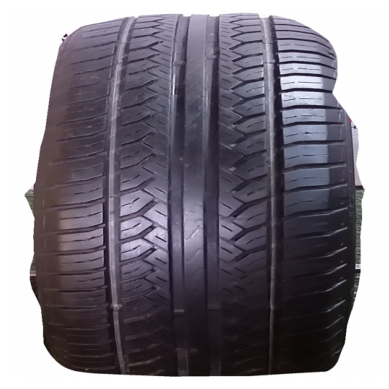

In [5]:
image_path = data_root / df.sample().iloc[0, 0]
img = read_image(image_path)


class Clahe(nn.Module):
    def __init__(self, clip_limit: float = 2.0):
        super().__init__()
        self.clip_limit = clip_limit
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit)

    def _apply_clahe(self, img: np.ndarray) -> np.ndarray:
        result = []
        for channel in img:
            result.append(self.clahe.apply(channel))

        return np.stack(result, axis=0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        device = x.device
        x_npy = x.cpu().numpy()
        x_clahe = self._apply_clahe(x_npy)

        return torch.tensor(x_clahe, device=device)


transform = transforms.Compose(
    [
        # Clahe(),
        lambda x: x / 255,
        transforms.Resize(
            (512, 512), interpolation=transforms.InterpolationMode.BICUBIC
        ),
    ]
)

transform_aug = transforms.Compose(
    [
        transform,
        # transforms.ToPILImage(),
        # transforms.RandAugment(
        #     num_ops=3, interpolation=transforms.InterpolationMode.BICUBIC
        # ),
        # transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        # transforms.RandomAffine(15, (0.05, 0.05), fill=255),
    ]
)

img = transform_aug(img)

plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.show()

In [6]:
train_dataset = ThreadDataset(df_train, data_root, transform_aug)
val_dataset = ThreadDataset(df_val, data_root, transform)

train_loader = DataLoader(train_dataset, shuffle=True, num_workers=4, batch_size=8)
val_loader = DataLoader(val_dataset, shuffle=False, num_workers=4, batch_size=16)

In [7]:
models = {}

# model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
# model.fc = nn.Sequential(nn.Linear(2048, 512), nn.ReLU(), nn.Linear(512, 1))

models["swin_v2"] = swin_v2_s(weights=Swin_V2_S_Weights.IMAGENET1K_V1)
models["swin_v2"].head = nn.Sequential(nn.Linear(768, 256), nn.ReLU(), nn.Linear(256, N_CLASSES))

model = swin_s(weights=Swin_S_Weights.IMAGENET1K_V1)
model.head = nn.Sequential(nn.Linear(768, 256), nn.ReLU(), nn.Linear(256, N_CLASSES))

models["effnet_b3"] = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
models["effnet_b3"].classifier = nn.Sequential(nn.Linear(1536, 512), nn.SiLU(), nn.Linear(512, N_CLASSES))

models["effnet_b7"] = efficientnet_b7(weights=EfficientNet_B7_Weights.IMAGENET1K_V1)
models["effnet_b7"].classifier = nn.Sequential(nn.Linear(2560, 512), nn.SiLU(), nn.Linear(512, N_CLASSES))

model = swin_v2_t(weights=Swin_V2_T_Weights.IMAGENET1K_V1)
model.features[0][0] = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=(5, 5), stride=(2, 2))
model.head = nn.Sequential(nn.Linear(768, 512), nn.GELU(), nn.Linear(512, N_CLASSES))

# model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_SWAG_LINEAR_V1)
# model.heads = nn.Sequential(nn.Linear(768, 512), nn.GELU(), nn.Linear(512, 1))

models["densenet201"] = densenet201(weights=DenseNet201_Weights.IMAGENET1K_V1)
models["densenet201"].classifier = nn.Sequential(nn.Linear(1920, 512), nn.ReLU(), nn.Linear(512, N_CLASSES))

models["googlenet"] = googlenet(weights=GoogLeNet_Weights.IMAGENET1K_V1)
models["googlenet"].fc = nn.Sequential(nn.Linear(1024, 512), nn.ReLU(), nn.Linear(512, N_CLASSES))

# model = convnext_small(weights=ConvNeXt_Small_Weights.IMAGENET1K_V1)
# model.classifier[-1] = nn.Sequential(nn.Linear(768, 512), nn.GELU(), nn.Linear(512, 1))

# model = regnet_y_8gf(weights=RegNet_Y_8GF_Weights.IMAGENET1K_V2)
# model.fc = nn.Sequential(nn.Linear(2016, 512), nn.ReLU(), nn.Linear(512, 1))

Downloading: "https://download.pytorch.org/models/swin_v2_s-637d8ceb.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_s-637d8ceb.pth
100%|██████████| 191M/191M [00:01<00:00, 176MB/s]  
Downloading: "https://download.pytorch.org/models/swin_s-5e29d889.pth" to /root/.cache/torch/hub/checkpoints/swin_s-5e29d889.pth
100%|██████████| 190M/190M [00:00<00:00, 225MB/s]  
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 185MB/s] 
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 228MB/s]  
Downloading: "https://download.pytorch.org/models/swin_v2_t-b137f0e2.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_t-b137f0e2.pth
100%|██████████| 109M/109M [00:00<00:00, 214MB/s] 
Downloa

In [8]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from copy import deepcopy
from tqdm import tqdm

def train_fn(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 10,
    min_depth: float = 1.0,
    max_depth: float = 10.0,
    step: float = 0.1
):
    """
    Trains a depth‐bin classifier with CrossEntropyLoss.
    
    Assumes:
      - model(images) returns logits of shape [B, n_classes]
      - train_loader / val_loader yield (images, labels_cls)
        where labels_cls is a LongTensor of class indices in [0..n_classes-1].
    """
    n_classes  = int((max_depth - min_depth) / step) + 1
    depth_bins = torch.linspace(min_depth, max_depth, n_classes).to(torch.float32)

    best_val_metric = -torch.inf
    best_model      = deepcopy(model).cpu()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    depth_bins = depth_bins.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.1, patience=3
    )

    for epoch in range(1, num_epochs+1):
        # ——— Training ———
        model.train()
        running_loss = 0.0

        for images, labels_cls in tqdm(train_loader, desc=f"Epoch {epoch} Train"):
            images    = images.to(device)
            labels_cls = labels_cls.to(device).long().squeeze()  # [B]

            optimizer.zero_grad()
            logits = model(images)                  # [B, n_classes]
            loss   = criterion(logits, labels_cls)  # cross‐entropy
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch}/{num_epochs}  Train CE Loss: {avg_loss:.4f}")

        # ——— Validation ———
        model.eval()
        sum_abs = 0.0
        count_within1 = 0
        total = 0

        with torch.no_grad():
            for images, labels_cls in tqdm(val_loader, desc=f"Epoch {epoch} Eval"):
                images    = images.to(device)
                labels_cls = labels_cls.to(device).long().squeeze()         # [B]
                labels_mm  = labels_cls.float() * step + min_depth         # [B]

                logits = model(images)                                   # [B, n_classes]
                probs  = F.softmax(logits, dim=1)                        # [B, n_classes]
                max_inds = probs.argmax(dim=1)                           # [B]
                preds_mm  = max_inds.float() * step + min_depth          # [B]

                abs_err = (preds_mm - labels_mm).abs()                   # [B]
                sum_abs += abs_err.sum().item()
                count_within1 += (abs_err <= 1.0).sum().item()
                total += abs_err.numel()

        mae      = sum_abs / total
        frac     = count_within1 / total
        print(
            f"Val MAE: {mae:.4f} mm, "
            f"Frac|err|≤1 mm: {frac:.4f}"
        )

        scheduler.step(frac)

        if frac > best_val_metric:
            best_val_metric = frac
            best_model = deepcopy(model).cpu()

    return best_model


In [9]:
torch.cuda.is_available()

True

In [10]:
trained_models: Dict[str, nn.Module] = {}
for model_name, model in models.items():
    print(f"TRAINING {model_name}")
    model = train_fn(
        model,
        train_loader,
        val_loader,
        num_epochs=5,
    )
    print()
    trained_models[model_name] = model

TRAINING swin_v2


Epoch 1 Train:  28%|██▊       | 41/145 [00:29<01:14,  1.40it/s]


KeyboardInterrupt: 